In [235]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [236]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px

## configurations

### general configurations

In [237]:
repo_dir = '/home/labs/amit/noamsh/repos/CAR_T'
data_dir_path = Path(repo_dir, "data")

In [238]:
sys.path.append(repo_dir)

### experiment configuration

to reproduce paper, run this notebook 3 time, while edditing the feature selection parmeters:

    1. use_cell_frequencies = True (all other False)
    2. use_TNFA_SIGNALING_VIA_NFKB_CD16_Mono = True (all other False)
    3. use_cell_frequencies = True, use_TNFA_SIGNALING_VIA_NFKB_CD16_Mono = True (all other False)


In [239]:
# feature selection
use_TNFA_SIGNALING_VIA_NFKB_CD16_Mono = True # will be used only is above is false
use_cell_frequencies = True

## data loading

### abundance + label

In [240]:
cell_abundance_dataset_path  = Path(data_dir_path, "cell_type_abundance_by_sample_group_normalized.csv")
cell_abundance_dataset = pd.read_csv(cell_abundance_dataset_path)
cell_abundance_dataset = cell_abundance_dataset.set_index('sample_id')

y = cell_abundance_dataset['response_3m']
cell_abandace = cell_abundance_dataset.drop(columns=['response_3m', 'LDH_prior_tx'])
cell_abandace.index = cell_abandace.index.rename("patient")

print(cell_abandace.shape)
print(cell_abandace.columns)

cell_abandace.head()

(42, 18)
Index(['B', 'CD4.CM', 'CD4.EM', 'CD4.Naive', 'CD8.CM', 'CD8.EM', 'CD8.naive',
       'Cycling', 'MAIT', 'NK.bright', 'NK.dim', 'Tregs', 'CD14 Mono',
       'CD16 Mono', 'DCs', 'Inter Mono', 'pDC', 'B_category'],
      dtype='object')


,B,CD4.CM,CD4.EM,CD4.Naive,CD8.CM,CD8.EM,CD8.naive,Cycling,MAIT,NK.bright,NK.dim,Tregs,CD14 Mono,CD16 Mono,DCs,Inter Mono,pDC,B_category
patient,,,,,,,,,,,,,,,,,,
GIL_01,0.00000,0.03413,0.06143,0.19027,0.11604,0.35239,0.01109,0.06997,0.02133,0.00939,0.11348,0.02048,0.80223,0.04625,0.03668,0.10207,0.01276,B_unknown
GIL_02,0.00053,0.01163,0.03594,0.17336,0.10994,0.40275,0.03066,0.02854,0.00951,0.01374,0.16490,0.01903,0.75158,0.16737,0.01263,0.06632,0.00211,B_unknown
GIL_03,0.00201,0.04025,0.04441,0.13393,0.19570,0.39695,0.01457,0.02776,0.01319,0.00694,0.07703,0.04927,0.68304,0.14933,0.03468,0.13102,0.00193,B_unknown
GIL_04,0.01039,0.08419,0.05155,0.22852,0.06014,0.32646,0.01890,0.06014,0.00344,0.01890,0.07216,0.07560,0.49444,0.36111,0.02222,0.12222,0.00000,B_unknown
GIL_05,0.00358,0.01944,0.01080,0.10151,0.09287,0.25702,0.00432,0.02592,0.02808,0.08423,0.36933,0.00648,0.60175,0.21765,0.03032,0.14960,0.00067,B_unknown


In [241]:
cell_group_abundance_dataset_path  = Path(data_dir_path, "cell_group_abundance_by_sample.csv")
cell_group_abundance = pd.read_csv(cell_group_abundance_dataset_path)
cell_group_abundance = cell_group_abundance[['patient_alias', 'cell_type', 'abundance']].groupby(by=['patient_alias', 'cell_type']).sum()['abundance'].unstack()
cell_group_abundance.index = cell_group_abundance.index.rename("patient")
cell_group_abundance = cell_group_abundance / 100
cell_group_abundance = cell_group_abundance.loc[cell_abandace.index]

cell_group_abundance["NKT"] = cell_group_abundance[["CD4 T", "CD8 T", "NK"]].sum(axis=1)
print(cell_group_abundance.shape)
cell_group_abundance.head()

(42, 6)


cell_type,B,CD4 T,CD8 T,Myeloid,NK,NKT
patient,,,,,,
GIL_01,0.00000,0.21345,0.35798,0.34853,0.08004,0.65147
GIL_02,0.00053,0.12441,0.28519,0.50079,0.08909,0.49869
GIL_03,0.00201,0.16304,0.36836,0.41787,0.04871,0.58011
GIL_04,0.01039,0.33506,0.35195,0.23377,0.06883,0.75584
GIL_05,0.00358,0.03941,0.09007,0.75947,0.10747,0.23695


In [242]:
cell_abandace = pd.concat([cell_abandace, cell_group_abundance.drop(columns="B")], axis=1)

### baseline

In [243]:
baseline_data_path = Path(data_dir_path, "patients_baseline_predictions.csv")
baseline_data = pd.read_csv(baseline_data_path)
baseline_data = baseline_data.rename(columns={'Unnamed: 0': 'sample_id'})
baseline_data = baseline_data.set_index('sample_id')

baseline_data.index = baseline_data.index.rename("patient")

print(baseline_data.shape)
print(baseline_data.columns)
baseline_data.head()

(42, 7)
Index(['NR', 'R', 'predicted', 'TRUE', 'n_trials', 'predicted_proba',
       'prediction_scores'],
      dtype='object')


,NR,R,predicted,TRUE,n_trials,predicted_proba,prediction_scores
patient,,,,,,,
GIL_01,20,10,NR,NR,30,0.333333,-0.466667
GIL_02,17,11,NR,NR,28,0.392857,-0.323810
GIL_03,12,12,NR,NR,24,0.500000,-0.066667
GIL_04,3,17,R,NR,20,0.850000,0.773333
GIL_05,6,14,R,NR,20,0.700000,0.413333


In [244]:
pd.testing.assert_series_equal(baseline_data["TRUE"], y, check_names=False)

### patient metadata

In [245]:
metadata_path = Path(data_dir_path, "2024_03_04 CART Clinical metadata analysed only V2.xlsx")
patient_metadata = pd.read_excel(metadata_path).dropna(subset="sample_name")
patient_metadata["Product {GIL: 0, NOV:1}"] = patient_metadata["Product"].map({"GIL": 0, "NOV":1})
patient_metadata["Sex {M: 0, F:1}"] = patient_metadata["Sex"].map({"M": 0, "F":1})
patient_metadata["sample_name"] = patient_metadata["sample_name"].apply(lambda x: x.split('/')[0])

# patient_metadata.columns

In [246]:
patient_map_path = Path(data_dir_path, "sample_names_ids.csv")
patient_map = pd.read_csv(patient_map_path)
patient_map.head()

,Unnamed: 0,sample_name,sample_id
0,1,Axi-01,GIL_01
1,2,Axi-02,GIL_02
2,3,Axi-03,GIL_03
3,4,Axi-04,GIL_04
4,5,Axi-05,GIL_05


In [247]:
patient_metadata = patient_metadata.merge(patient_map, on="sample_name", how="inner", validate="1:1")

In [248]:
# "Sex {M: 0, F:1}", "Pick_Ferritin"

patient_metadata = patient_metadata[["sample_id",'Day_7_Expansion (CAR T/ml blood)',  "Age", "Product {GIL: 0, NOV:1}"]]
patient_metadata = patient_metadata.set_index("sample_id")
patient_metadata.index = patient_metadata.index.rename("patient")

In [249]:
print(patient_metadata.shape)
print(patient_metadata.columns)
patient_metadata.head()

(43, 3)
Index(['Day_7_Expansion (CAR T/ml blood)', 'Age', 'Product {GIL: 0, NOV:1}'], dtype='object')


,Day_7_Expansion (CAR T/ml blood),Age,"Product {GIL: 0, NOV:1}"
patient,,,
GIL_01,14.7,73.17,0
GIL_02,136.0,47.44,0
GIL_03,47.0,71.62,0
GIL_04,NaN,70.16,0
GIL_05,3.2,72.82,0


### gene pathways

In [250]:
mye_pathways_path = Path(data_dir_path, "Myeloid_zscore_top10_padj_pathways.csv")
mye_pathways = pd.read_csv(mye_pathways_path)

print(mye_pathways.shape)
print(mye_pathways.columns)
mye_pathways.head()

(414, 7)
Index(['orig.ident', 'cell_type', 'cell_type_response', 'response_3m',
       'patient', 'zscore', 'cleaned_pathways'],
      dtype='object')


,orig.ident,cell_type,cell_type_response,response_3m,patient,zscore,cleaned_pathways
0,NR,CD16 Mono,CD16 Mono_NR,NR,GIL-01,0.090858,HALLMARK_APICAL_JUNCTION
1,NR,CD16 Mono,CD16 Mono_NR,NR,GIL-02,-0.046542,HALLMARK_APICAL_JUNCTION
2,NR,CD16 Mono,CD16 Mono_NR,NR,GIL-03,-0.059306,HALLMARK_APICAL_JUNCTION
3,NR,CD16 Mono,CD16 Mono_NR,NR,GIL-04,-0.013229,HALLMARK_APICAL_JUNCTION
4,NR,CD16 Mono,CD16 Mono_NR,NR,GIL-05,-0.010807,HALLMARK_APICAL_JUNCTION


In [251]:
mye_pathways['cleaned_pathways-cell_type'] = mye_pathways['cleaned_pathways'] + "-" + mye_pathways['cell_type'] 
mye_pathways_zscores = mye_pathways[['patient', 'zscore', 'cleaned_pathways-cell_type']].groupby(['patient', 'cleaned_pathways-cell_type'])["zscore"].sum().unstack(level=-1)
print(mye_pathways_zscores.shape)
print(mye_pathways_zscores.columns)
mye_pathways_zscores.head()
# mye_pathways_zscores

(42, 10)
Index(['HALLMARK_APICAL_JUNCTION-CD16 Mono', 'HALLMARK_APOPTOSIS-CD16 Mono',
       'HALLMARK_CHOLESTEROL_HOMEOSTASIS-CD16 Mono',
       'HALLMARK_INFLAMMATORY_RESPONSE-CD14 Mono',
       'HALLMARK_INFLAMMATORY_RESPONSE-CD16 Mono',
       'HALLMARK_INFLAMMATORY_RESPONSE-DCs', 'HALLMARK_P53_PATHWAY-DCs',
       'HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD14 Mono',
       'HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD16 Mono',
       'HALLMARK_TNFA_SIGNALING_VIA_NFKB-DCs'],
      dtype='object', name='cleaned_pathways-cell_type')


cleaned_pathways-cell_type,HALLMARK_APICAL_JUNCTION-CD16 Mono,HALLMARK_APOPTOSIS-CD16 Mono,HALLMARK_CHOLESTEROL_HOMEOSTASIS-CD16 Mono,HALLMARK_INFLAMMATORY_RESPONSE-CD14 Mono,HALLMARK_INFLAMMATORY_RESPONSE-CD16 Mono,HALLMARK_INFLAMMATORY_RESPONSE-DCs,HALLMARK_P53_PATHWAY-DCs,HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD14 Mono,HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD16 Mono,HALLMARK_TNFA_SIGNALING_VIA_NFKB-DCs
patient,,,,,,,,,,
GIL-01,0.090858,0.142722,0.103711,-0.026402,0.125739,-0.079013,0.040826,-0.001839,0.035825,-0.061448
GIL-02,-0.046542,0.016285,0.003678,-0.054138,0.034415,-0.163298,0.056375,-0.014066,0.009606,-0.120022
GIL-03,-0.059306,0.036100,-0.014916,-0.126769,-0.016796,-0.179905,0.005903,-0.068230,-0.001888,-0.073733
GIL-04,-0.013229,0.042234,0.017455,0.044129,0.053433,0.152858,0.241357,0.059288,0.025582,0.225406
GIL-05,-0.010807,0.004165,-0.009597,-0.072766,0.008753,-0.049080,0.004847,-0.043784,-0.046632,-0.002140


### merge data

In [252]:
patient_col = "patient"

cell_abandace.index = cell_abandace.index.astype("string").str.replace("-","_")
mye_pathways_zscores.index = mye_pathways_zscores.index.astype("string").str.replace("-","_")
patient_metadata.index = patient_metadata.index.astype("string").str.replace("-","_")

In [253]:
mye_pathways_zscores.loc["NOV_20"] = mye_pathways_zscores.mean()

In [254]:
print("abandace - mye: ", set(cell_abandace.index).difference(set(mye_pathways_zscores.index)))
print("mye - abandace: ", set(mye_pathways_zscores.index).difference(set(cell_abandace.index)))
###
print("metadate - mye: ", set(patient_metadata.index).difference(set(mye_pathways_zscores.index)))
print("mye - metadate: ", set(mye_pathways_zscores.index).difference(set(patient_metadata.index)))
####
print("metadata - abandace: ", set(patient_metadata.index).difference(set(cell_abandace.index)))
print("abandace - metadata: ", set(cell_abandace.index).difference(set(patient_metadata.index)))

print("NOV_06 not in metadata, NOV_20 not in mye, GIL_08 not in abandance")

abandace - mye:  set()
mye - abandace:  {'GIL_08'}
metadate - mye:  set()
mye - metadate:  set()
metadata - abandace:  {'GIL_08'}
abandace - metadata:  set()
NOV_06 not in metadata, NOV_20 not in mye, GIL_08 not in abandance


In [255]:
all_X = cell_abandace.reset_index().merge(mye_pathways_zscores.reset_index(), how="inner", on=patient_col)

In [256]:
all_X = all_X.merge(patient_metadata.reset_index(), on=patient_col, how="inner")

In [257]:
all_feats_names = {
    "mye_pathways": list(mye_pathways_zscores.columns),
    "abundance": list(cell_abandace.columns),
    "metadata": list(patient_metadata.columns)
}

In [258]:
all_X = all_X.set_index(patient_col)
print(all_X.shape, y.shape)
print(all_X.columns)

(42, 36) (42,)
Index(['B', 'CD4.CM', 'CD4.EM', 'CD4.Naive', 'CD8.CM', 'CD8.EM', 'CD8.naive',
       'Cycling', 'MAIT', 'NK.bright', 'NK.dim', 'Tregs', 'CD14 Mono',
       'CD16 Mono', 'DCs', 'Inter Mono', 'pDC', 'B_category', 'CD4 T', 'CD8 T',
       'Myeloid', 'NK', 'NKT', 'HALLMARK_APICAL_JUNCTION-CD16 Mono',
       'HALLMARK_APOPTOSIS-CD16 Mono',
       'HALLMARK_CHOLESTEROL_HOMEOSTASIS-CD16 Mono',
       'HALLMARK_INFLAMMATORY_RESPONSE-CD14 Mono',
       'HALLMARK_INFLAMMATORY_RESPONSE-CD16 Mono',
       'HALLMARK_INFLAMMATORY_RESPONSE-DCs', 'HALLMARK_P53_PATHWAY-DCs',
       'HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD14 Mono',
       'HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD16 Mono',
       'HALLMARK_TNFA_SIGNALING_VIA_NFKB-DCs',
       'Day_7_Expansion (CAR T/ml blood)', 'Age', 'Product {GIL: 0, NOV:1}'],
      dtype='object')


In [259]:
all_X["Product {GIL: 0, NOV:1}"].value_counts()

Product {GIL: 0, NOV:1}
1    24
0    18
Name: count, dtype: int64

In [260]:
class_map = {"R":1, "NR":0}
y = y.map(class_map)

In [261]:
y = y.loc[all_X.index]
y.value_counts()

response_3m
1    29
0    13
Name: count, dtype: int64

## feature_selection

In [262]:
single_pathway = "HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD16 Mono"

featurs = []
if use_TNFA_SIGNALING_VIA_NFKB_CD16_Mono:
    featurs += [single_pathway]  
if use_cell_frequencies:
    featurs += all_feats_names["abundance"]

X = all_X[featurs]

In [263]:
X = X.dropna(axis=1)

In [264]:
B_cat_map = {'B_unknown': 0, 'B_tumor': -1, 'B_healthy': 1}
if 'B_category' in featurs:
    X['B_category'] = X['B_category'].replace(B_cat_map)

/tmp/ipykernel_24217/3526030321.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



### engeneering


In [265]:
def normalize_feat(X, feat_name):
    X[feat_name] = (X[feat_name] - X[feat_name].mean())/X[feat_name].std()

In [266]:
if use_TNFA_SIGNALING_VIA_NFKB_CD16_Mono:
    normalize_feat(X, single_pathway)

### view

In [267]:
print(X.shape)
print(X.columns)
X.head()

(42, 24)
Index(['HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD16 Mono', 'B', 'CD4.CM', 'CD4.EM',
       'CD4.Naive', 'CD8.CM', 'CD8.EM', 'CD8.naive', 'Cycling', 'MAIT',
       'NK.bright', 'NK.dim', 'Tregs', 'CD14 Mono', 'CD16 Mono', 'DCs',
       'Inter Mono', 'pDC', 'B_category', 'CD4 T', 'CD8 T', 'Myeloid', 'NK',
       'NKT'],
      dtype='object')


,HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD16 Mono,B,CD4.CM,CD4.EM,CD4.Naive,CD8.CM,CD8.EM,CD8.naive,Cycling,MAIT,...,CD16 Mono,DCs,Inter Mono,pDC,B_category,CD4 T,CD8 T,Myeloid,NK,NKT
patient,,,,,,,,,,,,,,,,,,,,,
GIL_01,0.771438,0.00000,0.03413,0.06143,0.19027,0.11604,0.35239,0.01109,0.06997,0.02133,...,0.04625,0.03668,0.10207,0.01276,0,0.21345,0.35798,0.34853,0.08004,0.65147
GIL_02,0.324082,0.00053,0.01163,0.03594,0.17336,0.10994,0.40275,0.03066,0.02854,0.00951,...,0.16737,0.01263,0.06632,0.00211,0,0.12441,0.28519,0.50079,0.08909,0.49869
GIL_03,0.127966,0.00201,0.04025,0.04441,0.13393,0.19570,0.39695,0.01457,0.02776,0.01319,...,0.14933,0.03468,0.13102,0.00193,0,0.16304,0.36836,0.41787,0.04871,0.58011
GIL_04,0.596658,0.01039,0.08419,0.05155,0.22852,0.06014,0.32646,0.01890,0.06014,0.00344,...,0.36111,0.02222,0.12222,0.00000,0,0.33506,0.35195,0.23377,0.06883,0.75584
GIL_05,-0.635481,0.00358,0.01944,0.01080,0.10151,0.09287,0.25702,0.00432,0.02592,0.02808,...,0.21765,0.03032,0.14960,0.00067,0,0.03941,0.09007,0.75947,0.10747,0.23695


## cross validation hp search

In [268]:
from sklearn.model_selection import train_test_split
from clinical_predictions.optuna_optimization import get_best_model_with_optuna

In [269]:
from sklearn.decomposition import PCA

def pca_fit_transform_train_transform_test(X_train, X_test, feats_to_pca, pc_name, n_pcs=3):
    assert all([feat in X_train.columns for feat in feats_to_pca]), ValueError("not all feats in X_train")
    assert all([feat in X_test.columns for feat in feats_to_pca]), ValueError("not all feats in X_test")

    pca = PCA(n_components=n_pcs)
    pca_X_train = pca.fit_transform(X_train[feats_to_pca])
    pca_X_test = pca.transform(X_test[feats_to_pca])

    pc_names = [f"{pc_name}_pc_{i}" for i in range(n_pcs)]
    X_train_transformed = pd.concat([X_train.drop(columns=feats_to_pca), 
                                       pd.DataFrame(pca_X_train, columns=pc_names, index=X_train.index)],
                                      axis=1)
    X_test_transformed = pd.concat([X_test.drop(columns=feats_to_pca), 
                                        pd.DataFrame(pca_X_test, columns=pc_names, index=X_test.index)],
                                    axis=1)
    
    return X_train_transformed, X_test_transformed


In [270]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [271]:
best_model, best_trail = get_best_model_with_optuna(X_train, y_train, precision_alpha = 0, n_trials=100)

[I 2024-05-26 15:55:04,032] A new study created in memory with name: no-name-aff298fa-9e83-47d1-bbf6-b71f9415ff72
[I 2024-05-26 15:55:04,109] Trial 0 finished with value: 0.7803121076950292 and parameters: {'classifier': 'LogisticRegression', 'logistic_regression_c': 3.21995318833683, 'logr_penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7803121076950292.
[I 2024-05-26 15:55:04,453] Trial 1 finished with value: 0.5442093925907863 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 1, 'rf_n_estimators': 30, 'rf_max_samples': 0.8, 'rf_class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.7803121076950292.
[I 2024-05-26 15:55:04,525] Trial 2 finished with value: 0.7480008270183203 and parameters: {'classifier': 'LogisticRegression', 'logistic_regression_c': 0.0900527495655774, 'logr_penalty': 'l2', 'class_weight': None}. Best is trial 0 with value: 0.7803121076950292.
[I 2024-05-26 15:55:04,797] Trial 3 finished with value: 0.42857759154

In [272]:
print(best_trail.user_attrs["best_booster"])
pd.DataFrame(best_trail.user_attrs["scores"])

LogisticRegression(C=0.29000665574146073, penalty='l1', solver='liblinear')


,fit_time,score_time,test_accuracy,test_precision,test_f1,test_f1_weighted,test_f1_macro
0,0.001539,0.006544,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.001603,0.006539,0.777778,0.666667,0.800000,0.772222,0.775000
2,0.001499,0.006539,0.666667,1.000000,0.727273,0.692641,0.649351
3,0.001532,0.006681,0.666667,0.800000,0.727273,0.675325,0.649351
4,0.001505,0.006555,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.001500,0.006579,0.888889,1.000000,0.933333,0.903704,0.800000
6,0.001519,0.006534,0.888889,0.857143,0.923077,0.882051,0.861538
7,0.001571,0.006547,1.000000,1.000000,1.000000,1.000000,1.000000


## evaluation - on train set

#### prep

In [273]:
from evaluation.visualizations import plot_ROC_PRauc_CM_stem

In [274]:
def predict_train_test(model, X_1, X_2):
    y_train_pred = model.predict(X_1)
    y_train_proba = model.predict_proba(X_1)[:,1]
    y_test_pred = model.predict(X_2)
    y_test_proba = model.predict_proba(X_2)[:,1]
    return y_train_pred, y_train_proba, y_test_pred, y_test_proba

from sklearn.base import clone
    
def predict_using_all_other(model, X, y, return_trained_models=False, use_pca_of_feats=None, pc_name="feature"):
    
    y_pred_proba = {}
    y_pred = {}
    trained_models_dict = {}
    for pid in y.index:
        _model = clone(model)
        X_train = X.drop(pid)
        y_train = y.drop(pid)

        X_pred = X.loc[pid]
        X_pred = pd.DataFrame(X_pred).T
        
        if not use_pca_of_feats is None:
            X_train, X_pred = pca_fit_transform_train_transform_test(X_train, X_pred, feats_to_pca=use_pca_of_feats, pc_name=pc_name)
        _model.fit(X_train, y_train)
        
        pred = _model.predict(X_pred)[0]
        proba_ref = _model.predict_proba(X_pred)[0][1]
        y_pred[pid] = pred
        y_pred_proba[pid] = proba_ref
        trained_models_dict[pid] = _model
    
    y_proba_pred = pd.Series(y_pred_proba)
    y_pred = pd.Series(y_pred)
    if return_trained_models:
        return y_pred, y_proba_pred, trained_models_dict
    return y_pred, y_proba_pred
    # y_proba_pred.hist()

### response

In [275]:
best_model

LogisticRegression(C=0.29000665574146073, penalty='l1', solver='liblinear')

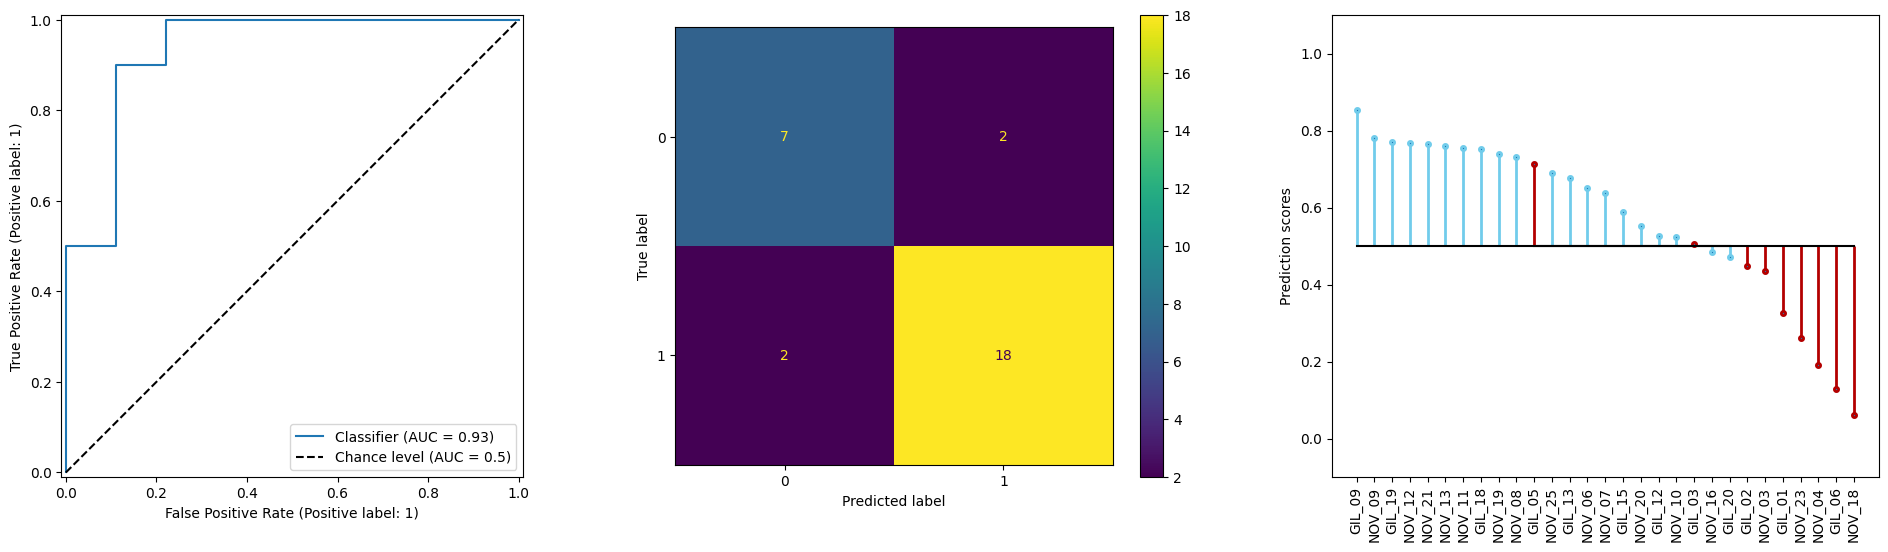

In [276]:
best_model.fit(X_train, y_train)
y_train_pred, y_train_proba, y_test_pred, y_test_proba = predict_train_test(best_model, X_train, X_test)
plot_ROC_PRauc_CM_stem(y_train, y_train_pred, y_train_proba, pos_label=1)

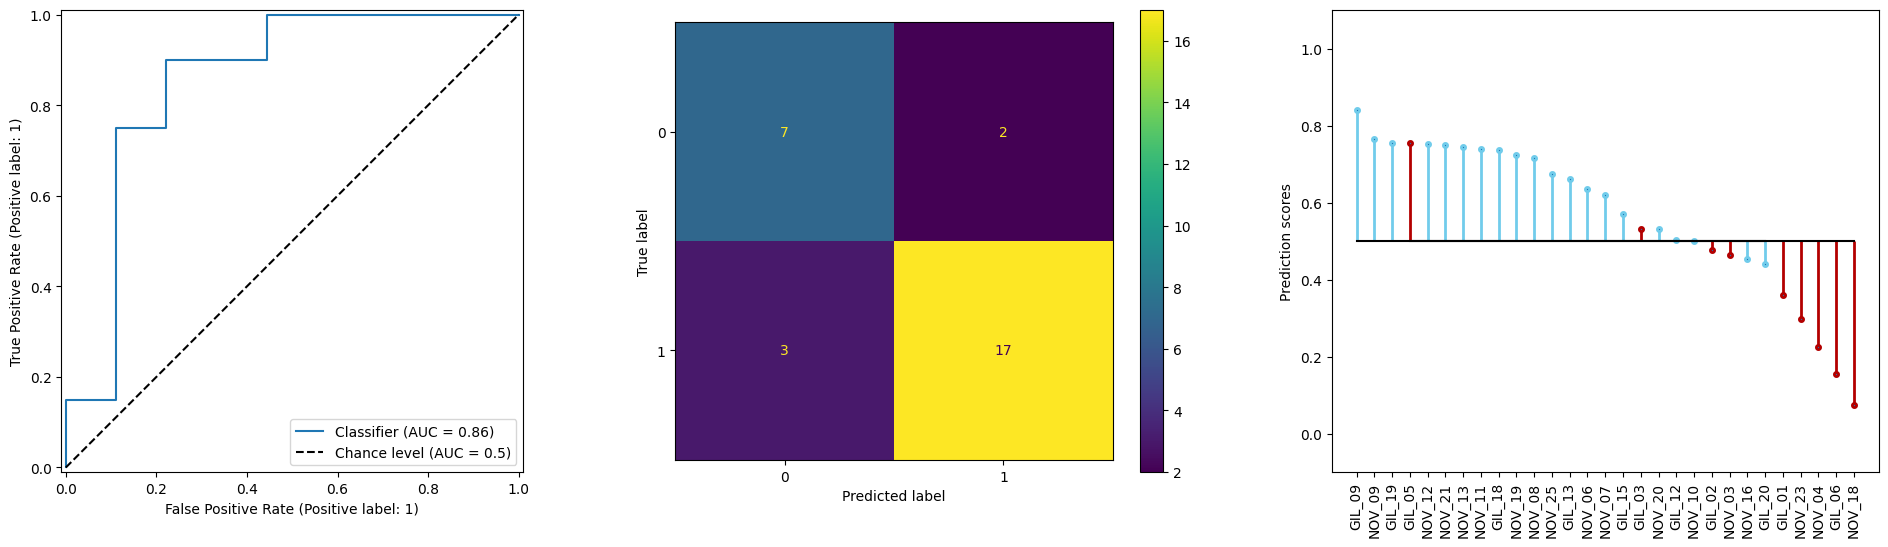

In [277]:
y_train_pred, y_train_proba, models_dict= predict_using_all_other(best_model, X_train, y_train, return_trained_models=True)
plot_ROC_PRauc_CM_stem(y_train, y_train_pred, y_train_proba, pos_label=best_model.classes_[1])

In [278]:
df = "NONE"
num_highest = 3
try:
    bad_patients = y_train_proba[y_train==0].sort_values().iloc[-num_highest:]
    good_patient = y_train_proba[y_train==1].sort_values().iloc[-num_highest:]
    assert all(y[bad_patients.index] == 0)
    assert all(y[good_patient.index] == 1)
    df = pd.concat([X.loc[bad_patients.index], X.loc[good_patient.index]])
except:
    print("ERROR")
df

,HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD16 Mono,B,CD4.CM,CD4.EM,CD4.Naive,CD8.CM,CD8.EM,CD8.naive,Cycling,MAIT,...,CD16 Mono,DCs,Inter Mono,pDC,B_category,CD4 T,CD8 T,Myeloid,NK,NKT
GIL_02,0.324082,0.00053,0.01163,0.03594,0.17336,0.10994,0.40275,0.03066,0.02854,0.00951,...,0.16737,0.01263,0.06632,0.00211,0,0.12441,0.28519,0.50079,0.08909,0.49869
GIL_03,0.127966,0.00201,0.04025,0.04441,0.13393,0.19570,0.39695,0.01457,0.02776,0.01319,...,0.14933,0.03468,0.13102,0.00193,0,0.16304,0.36836,0.41787,0.04871,0.58011
GIL_05,-0.635481,0.00358,0.01944,0.01080,0.10151,0.09287,0.25702,0.00432,0.02592,0.02808,...,0.21765,0.03032,0.14960,0.00067,0,0.03941,0.09007,0.75947,0.10747,0.23695
GIL_19,-0.891615,0.00048,0.05523,0.05523,0.15407,0.22965,0.31468,0.02907,0.01308,0.01526,...,0.15049,0.08439,0.14346,0.03938,0,0.20546,0.38649,0.34052,0.06705,0.65900
NOV_09,-0.937264,0.00000,0.05542,0.03401,0.17254,0.14484,0.40554,0.01385,0.02519,0.01259,...,0.26077,0.04989,0.12018,0.00907,0,0.19919,0.37895,0.35709,0.06478,0.64292
GIL_09,-1.359438,0.00000,0.08322,0.08886,0.34979,0.14245,0.17207,0.02821,0.01975,0.01269,...,0.25397,0.23016,0.11905,0.02381,0,0.47186,0.30778,0.15090,0.06946,0.84910


In [279]:
try:
    plot_df = X.copy()
    plot_df["y_pred"] = y_train_proba
    plot_df["y_true"] = y
    # featurs = single_pathway, "HALLMARK_INFLAMMATORY_RESPONSE-CD16 Mono", # "HALLMARK_APICAL_JUNCTION-CD16 Mono",
    fig = px.scatter(plot_df.reset_index(), x=single_pathway,
                     y= "CD16 Mono", 
                     color="y_pred",
                     # size='petal_length',
                     hover_data=['patient', "y_pred", "B", "y_true"]
                    )
    fig.show()
except ValueError:
    pass

## explainability and error analisys

In [280]:
import shap

def print_shap_plots(model, X):
    try: # tree
        explainer = shap.TreeExplainer(model)
    except:
        try: # kernel
            explainer = shap.Explainer(model, X) 
        except:
            explainer = shap.KernelExplainer(model.predict, X)
    shap_values = explainer(X)
    if len(shap_values.shape) >2:
        shap_values = shap_values[:,:,1]
    shap.plots.beeswarm(shap_values)
    shap.plots.bar(shap_values, max_display=5)
    return shap_values


### response

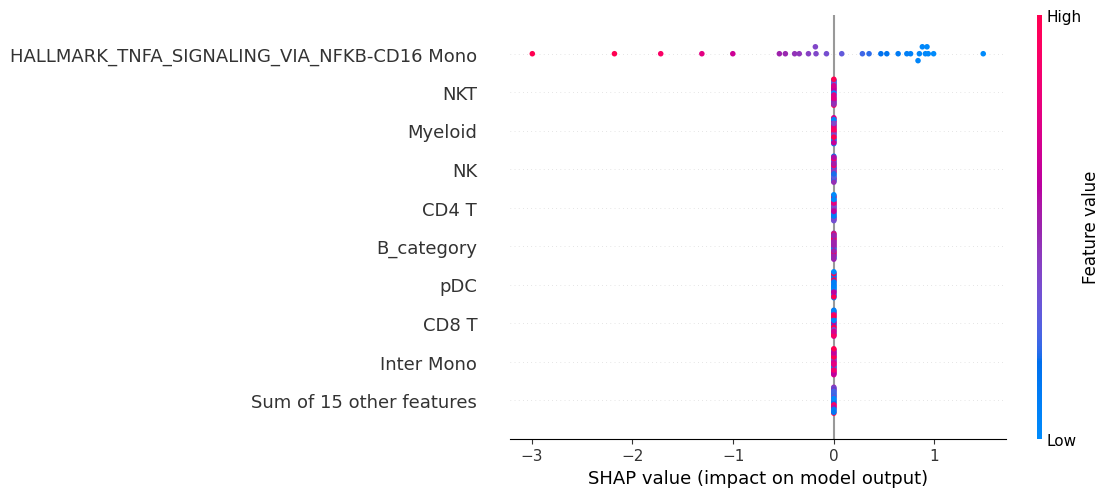

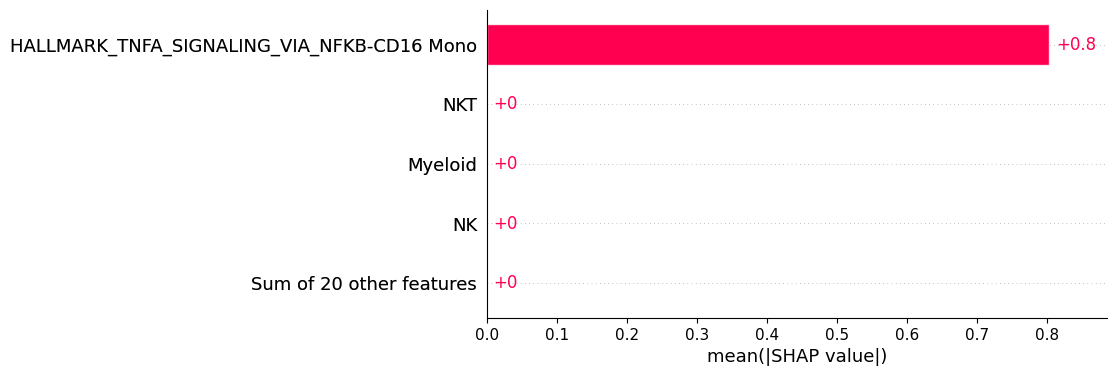

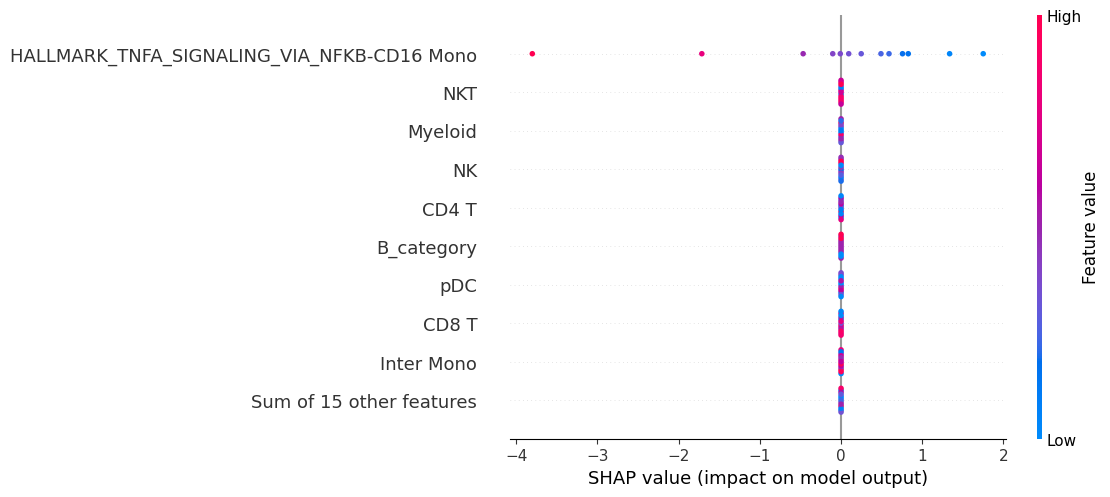

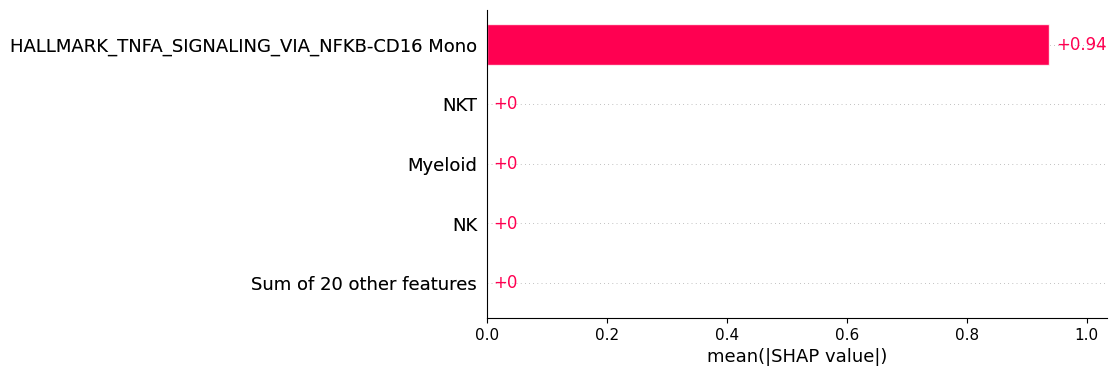

In [281]:
_ = print_shap_plots(best_model, X_train)
_ = print_shap_plots(best_model, X_test)

## test

In [282]:
import numpy as np
from sklearn import metrics
def print_metrics(y_true, y_score):
    report = metrics.classification_report(y_true, y_score, output_dict=True)
    print_report = {
        "R precision": round(report['1']['precision'], 3),
        "NR precision": round(report['0']['precision'], 3),
        'accuracy': round(report['accuracy'],3)
    }
    print_repors_list = [f"{k}: {v}" for k,v in print_report.items()]
    print("\n".join(print_repors_list))

R precision: 1.0
NR precision: 0.8
accuracy: 0.923


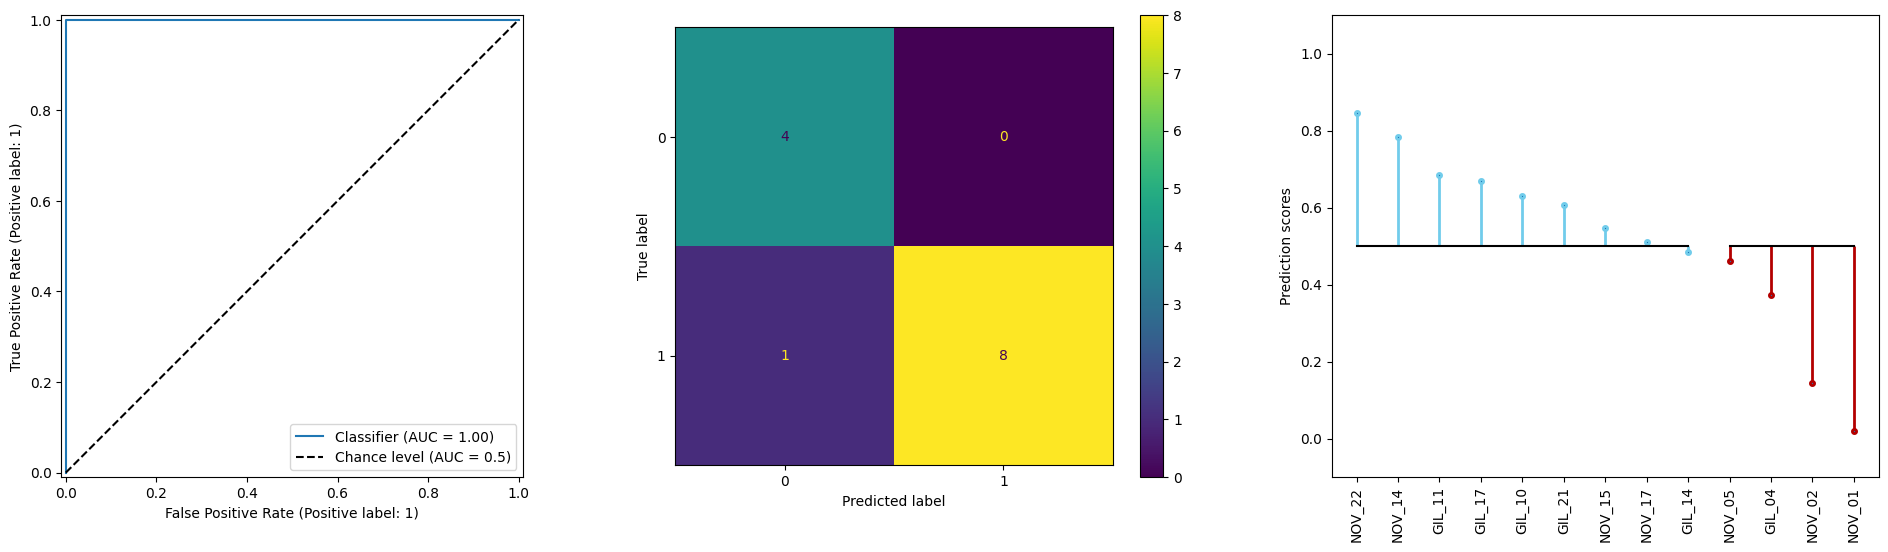

In [283]:
print_metrics(y_test, y_test_pred)
plot_ROC_PRauc_CM_stem(y_test, y_test_pred, y_test_proba, pos_label=best_model.classes_[1])

R precision: 0.875
NR precision: 0.9
accuracy: 0.881


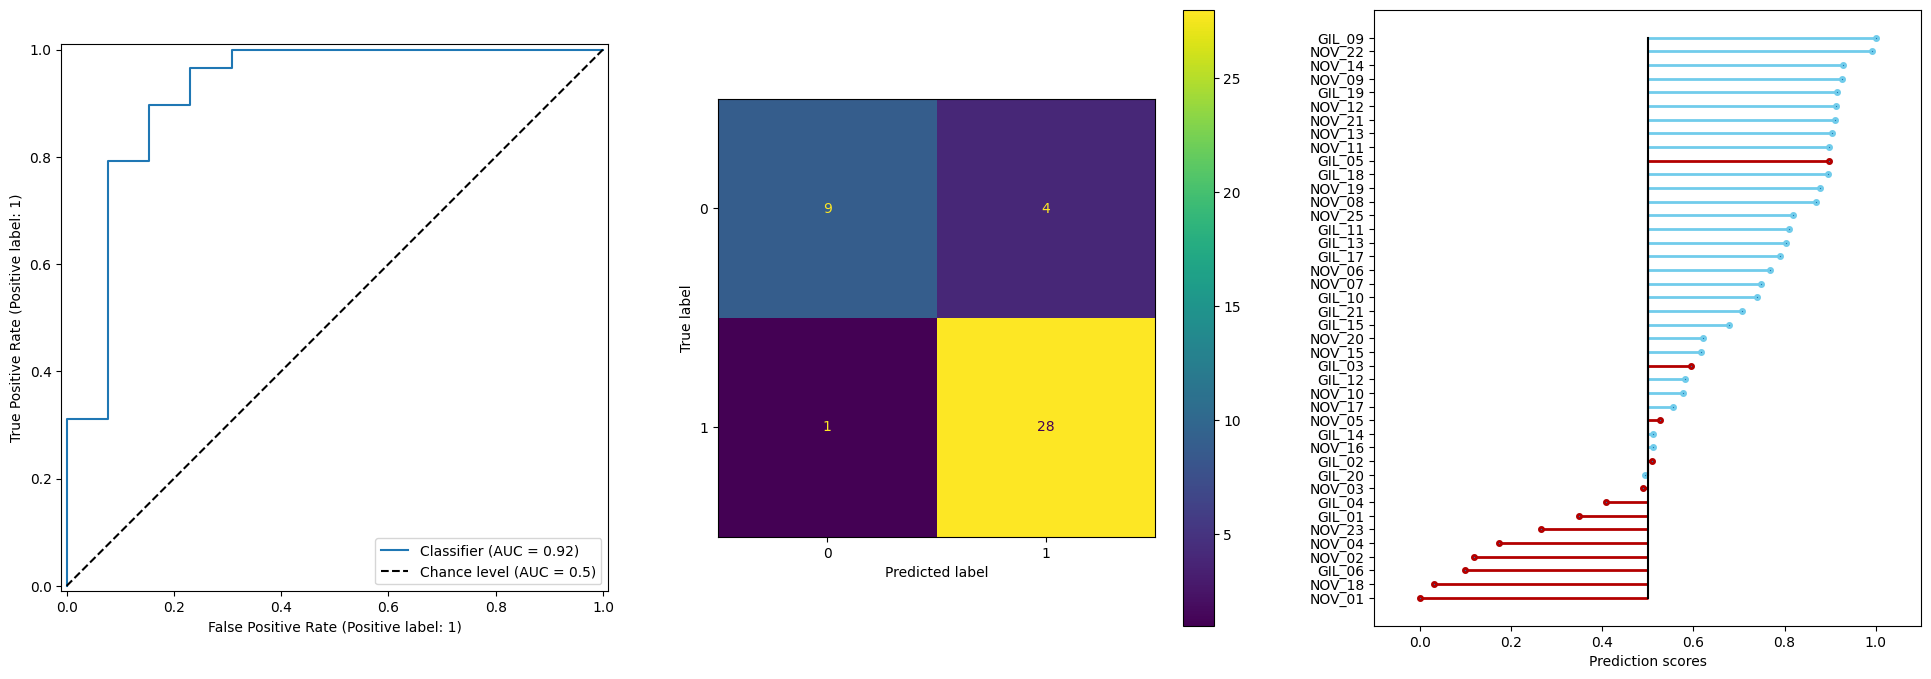

In [284]:
pca_feats = None
    
y_pred, y_proba = predict_using_all_other(best_model, X, y, use_pca_of_feats=pca_feats, pc_name="mye_pathways")
print_metrics(y, y_pred)
plot_ROC_PRauc_CM_stem(y, y_pred, y_proba, flip_stem=True, use_all_score_range=True)

In [285]:
df = "NONE"
num_highest = 3
try:
    bad_patients = y_proba[y==0].sort_values().iloc[-num_highest:]
    good_patient = y_proba[y==1].sort_values().iloc[-num_highest:]
    assert all(y[bad_patients.index] == 0)
    assert all(y[good_patient.index] == 1)
    df = pd.concat([X.loc[bad_patients.index], X.loc[good_patient.index]])
except:
    print("ERROR")
df

,HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD16 Mono,B,CD4.CM,CD4.EM,CD4.Naive,CD8.CM,CD8.EM,CD8.naive,Cycling,MAIT,...,CD16 Mono,DCs,Inter Mono,pDC,B_category,CD4 T,CD8 T,Myeloid,NK,NKT
NOV_05,0.284578,0.00000,0.01216,0.02736,0.06383,0.11246,0.48024,0.00000,0.01520,0.01520,...,0.05606,0.03797,0.11031,0.00000,0,0.05896,0.22676,0.62698,0.08730,0.37302
GIL_03,0.127966,0.00201,0.04025,0.04441,0.13393,0.19570,0.39695,0.01457,0.02776,0.01319,...,0.14933,0.03468,0.13102,0.00193,0,0.16304,0.36836,0.41787,0.04871,0.58011
GIL_05,-0.635481,0.00358,0.01944,0.01080,0.10151,0.09287,0.25702,0.00432,0.02592,0.02808,...,0.21765,0.03032,0.14960,0.00067,0,0.03941,0.09007,0.75947,0.10747,0.23695
NOV_14,-0.948122,0.02587,0.04173,0.04869,0.30551,0.09898,0.15944,0.12360,0.00321,0.02033,...,0.31188,0.14851,0.13861,0.02970,1,0.41580,0.33866,0.09501,0.12465,0.87911
NOV_22,-1.302815,0.09268,0.11820,0.48367,0.20062,0.03110,0.04199,0.01089,0.02177,0.01400,...,0.94059,0.00000,0.02970,0.00000,-1,0.69634,0.08293,0.12317,0.00488,0.78415
GIL_09,-1.359438,0.00000,0.08322,0.08886,0.34979,0.14245,0.17207,0.02821,0.01975,0.01269,...,0.25397,0.23016,0.11905,0.02381,0,0.47186,0.30778,0.15090,0.06946,0.84910


## hard test - external validation

### load data

#### cell type + y + product

In [286]:
haradvala_cell_freq = pd.read_csv(Path(data_dir_path, 'haradvala_cell_type_abundance_by_response_complete_renamed.csv'))
haradvala_cell_freq = haradvala_cell_freq.set_index('sample_id')

haradvala_cell_freq = haradvala_cell_freq.rename(columns={"Product":"Product {GIL: 0, NOV:1}"})

class_map = {"R":1, "NR":0}
y_hard_test = haradvala_cell_freq["response"].map(class_map)
y_hard_test.index = y_hard_test.index.rename("patient")
haradvala_cell_freq = haradvala_cell_freq.drop(columns="response")
haradvala_cell_freq.index = haradvala_cell_freq.index.rename("patient")

haradvala_cell_freq.shape, haradvala_cell_freq.columns
# y_hard_test

((20, 17),
 Index(['B', 'CD4.EM', 'CD4.Naive', 'CD8.CM', 'CD8.EM', 'CD8.naive', 'Cycling',
        'DCs', 'GD', 'CD14 Mono', 'CD16 Mono', 'Inter Mono', 'NK.bright',
        'NK.dim', 'Tregs', 'pDC', 'Product {GIL: 0, NOV:1}'],
       dtype='object'))

In [287]:
y_hard_test = y_hard_test.loc[haradvala_cell_freq.index]
y_hard_test.shape

(20,)

In [288]:
haradvala_metadata = haradvala_cell_freq[["Product {GIL: 0, NOV:1}"]]
haradvala_cell_freq = haradvala_cell_freq.drop(columns="Product {GIL: 0, NOV:1}")

In [289]:
haradvala_cell_freq.head()

,B,CD4.EM,CD4.Naive,CD8.CM,CD8.EM,CD8.naive,Cycling,DCs,GD,CD14 Mono,CD16 Mono,Inter Mono,NK.bright,NK.dim,Tregs,pDC
patient,,,,,,,,,,,,,,,,
Patient10-Baseline,0.00116,0.01906,0.03481,0.06797,0.28844,0.02031,0.01243,0.06158,0.21177,0.54239,0.23534,0.14973,0.06216,0.26813,0.01492,0.01097
Patient11-Baseline,0.05611,0.02823,0.07177,0.06029,0.37847,0.05502,0.02392,0.05119,0.08804,0.56256,0.16391,0.18407,0.03923,0.24833,0.00670,0.03826
Patient12-Baseline,0.08068,0.15756,0.21360,0.06109,0.01562,0.47405,0.01102,0.22963,0.00184,0.54074,0.01481,0.12593,0.00735,0.00276,0.05512,0.08889
Patient13-Baseline,0.00015,0.02715,0.05674,0.08180,0.53498,0.05117,0.03829,0.06704,0.06892,0.51827,0.19586,0.21205,0.01218,0.12113,0.00766,0.00678
Patient14-Baseline,0.00232,0.15198,0.14711,0.05957,0.01945,0.45228,0.03465,0.17626,0.00608,0.66187,0.05396,0.09113,0.02675,0.03647,0.06565,0.01679


#### cell group

In [290]:
raw_group_df = pd.read_csv(Path(data_dir_path, 'Harvdhala_cell_group_abundance_by_response.csv'))
group_df = raw_group_df[["patient_alias", "cell_type", "abundance"]].groupby(by=["patient_alias", "cell_type"]).sum()[ "abundance"].unstack(level=-1)
group_df.index = group_df.index.rename("patient")
group_df = group_df.rename(columns={'myeloid': 'Myeloid'})
group_df = group_df/100
group_df.head()

cell_type,B,NKT,Myeloid
patient,,,
Patient10-Baseline,0.00116,0.49971,0.49913
Patient11-Baseline,0.05611,0.49003,0.45386
Patient12-Baseline,0.08068,0.85531,0.06400
Patient13-Baseline,0.00015,0.54175,0.45810
Patient14-Baseline,0.00232,0.64311,0.35458


#### mye pathways

In [291]:
haradvala_mye_pathways = pd.read_csv(Path(data_dir_path, 'Myeloid_Modulescore_all_pathways5genes.csv'))
haradvala_mye_pathways['cell_type'] = haradvala_mye_pathways['cell_type'].apply(lambda x: " ".join(x.split(".")[::-1]))
haradvala_mye_pathways['cleaned_pathways-cell_type'] = haradvala_mye_pathways['cleaned_pathways'] + "-" + haradvala_mye_pathways['cell_type'] 
haradvala_mye_pathways = haradvala_mye_pathways[['Patient', 'zscore', 'cleaned_pathways-cell_type']].groupby(['Patient', 'cleaned_pathways-cell_type'])["zscore"].sum().unstack(level=-1)
haradvala_mye_pathways.index = haradvala_mye_pathways.index.rename("patient")
haradvala_mye_pathways.index = pd.Series(haradvala_mye_pathways.index).apply(lambda x: f"Patient{int(x[-2:])}-Baseline")

haradvala_mye_pathways.head()

cleaned_pathways-cell_type,HALLMARK_ALLOGRAFT_REJECTION-CD14 Mono,HALLMARK_ALLOGRAFT_REJECTION-CD16 Mono,HALLMARK_ALLOGRAFT_REJECTION-DCs,HALLMARK_ALLOGRAFT_REJECTION-Inter Mono,HALLMARK_APICAL_JUNCTION-CD14 Mono,HALLMARK_APOPTOSIS-CD14 Mono,HALLMARK_INTERFERON_GAMMA_RESPONSE-CD14 Mono,HALLMARK_INTERFERON_GAMMA_RESPONSE-CD16 Mono,HALLMARK_INTERFERON_GAMMA_RESPONSE-Inter Mono,HALLMARK_MITOTIC_SPINDLE-CD14 Mono,HALLMARK_MYOGENESIS-CD14 Mono,HALLMARK_OXIDATIVE_PHOSPHORYLATION-CD14 Mono,HALLMARK_P53_PATHWAY-CD14 Mono,HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD16 Mono,HALLMARK_TNFA_SIGNALING_VIA_NFKB-Inter Mono,HALLMARK_TNFA_SIGNALING_VIA_NFKB-pDC
patient,,,,,,,,,,,,,,,,
Patient6-Baseline,-0.018701,-0.030059,0.265296,0.069634,0.269521,-0.012281,-0.012647,-0.122846,0.086879,-0.005489,-0.051470,-0.018093,0.235698,-0.307336,-0.065567,-0.107537
Patient8-Baseline,0.012370,-0.009236,0.238160,0.066933,0.227239,-0.003677,0.044064,-0.133693,0.067664,-0.003237,-0.037088,-0.004810,0.188948,-0.291964,-0.076645,-0.072625
Patient9-Baseline,-0.057831,-0.020834,0.258224,-0.113644,0.309559,0.004194,-0.108485,0.054646,-0.074944,-0.005811,0.002530,-0.067837,0.288071,-0.247962,-0.054727,0.430147
Patient10-Baseline,-0.029671,-0.027105,0.309100,0.015882,0.260656,-0.009460,-0.032447,-0.125522,-0.007562,-0.004443,-0.021933,-0.048278,0.264188,-0.287157,-0.040718,0.071272
Patient11-Baseline,0.039429,-0.022641,0.236334,0.156200,0.221235,-0.017345,0.144935,-0.117095,0.154091,0.000302,-0.042162,0.013804,0.186603,-0.320936,-0.086839,-0.189018


In [292]:
if use_TNFA_SIGNALING_VIA_NFKB_CD16_Mono:
    normalize_feat(haradvala_mye_pathways, single_pathway)

In [293]:
df = haradvala_mye_pathways.copy()
show_feature = mon_ratio_name
if show_feature in df.columns:    
    df["label"] = y_hard_test.map({1:"R", 0: "NR"})
    fig = px.box(df, x="label", y=single_pathway, color="label", points="all", width=600, height=400, log_y=False)
    
    fig.show()

#### combine

In [294]:
all_X_hard_test= pd.concat([haradvala_cell_freq.drop(columns="B"), group_df , haradvala_mye_pathways[single_pathway]], axis=1)

In [295]:
X_hard_test = all_X_hard_test.copy()
if not use_TNFA_SIGNALING_VIA_NFKB_CD16_Mono:
    X_hard_test = X_hard_test.drop(columns=single_pathway)
common_feats = list(set(X).intersection(set(X_hard_test)))
                    
X_trasnformed = X[common_feats]
X_hard_test_transformed = X_hard_test[common_feats]

X_hard_test_transformed.columns

Index(['CD16 Mono', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD16 Mono', 'CD4.Naive',
       'CD14 Mono', 'Cycling', 'CD8.EM', 'NK.bright', 'CD8.CM', 'CD4.EM',
       'NKT', 'DCs', 'B', 'NK.dim', 'Tregs', 'Myeloid', 'Inter Mono', 'pDC',
       'CD8.naive'],
      dtype='object')

### evaluate

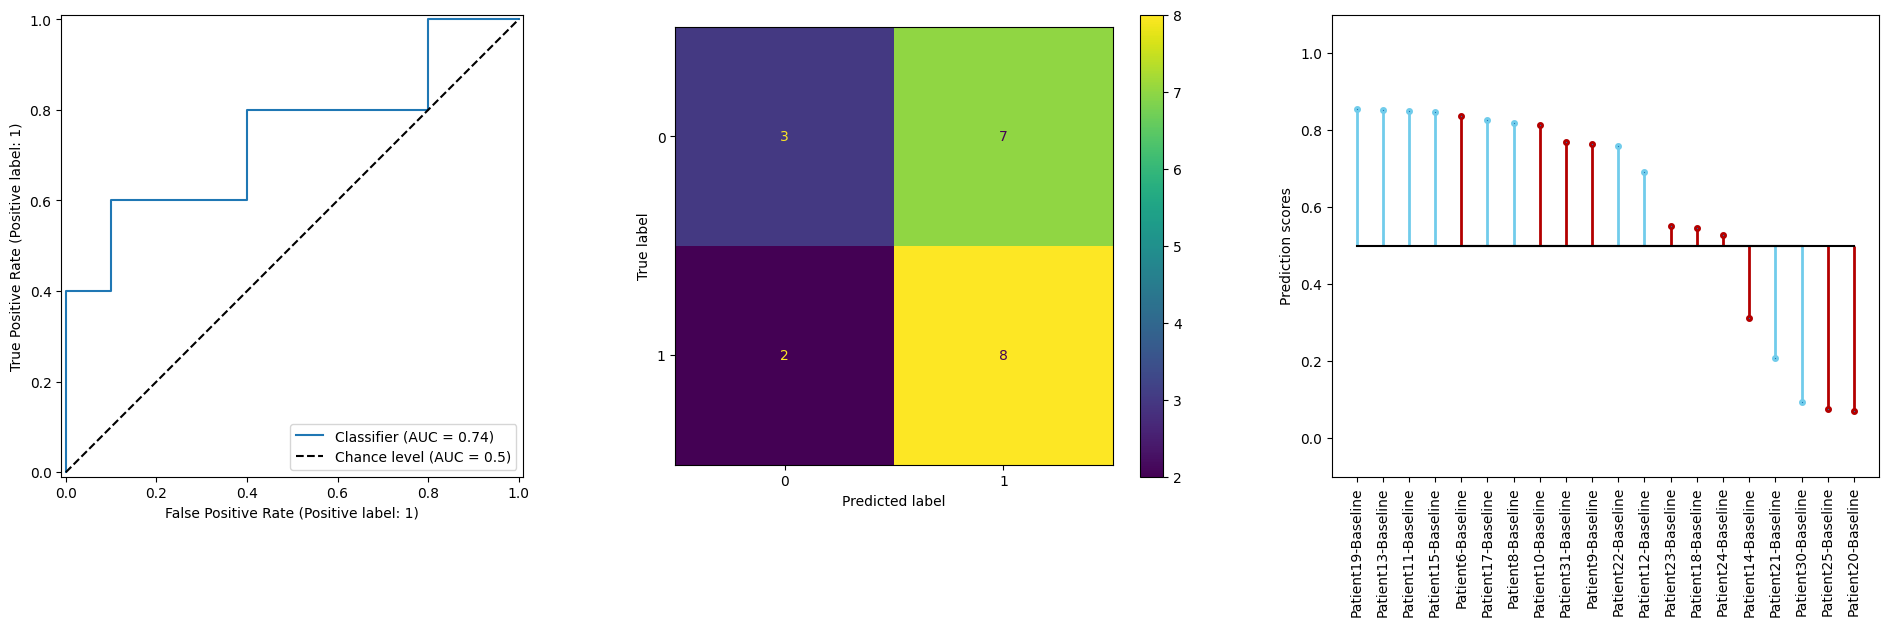

In [296]:
best_model.fit(X_trasnformed,y)
y_hard_test_pred = best_model.predict(X_hard_test_transformed)
y_hard_test_proba = best_model.predict_proba(X_hard_test_transformed)[:,1]
plot_ROC_PRauc_CM_stem(y_hard_test, y_hard_test_pred, y_hard_test_proba)

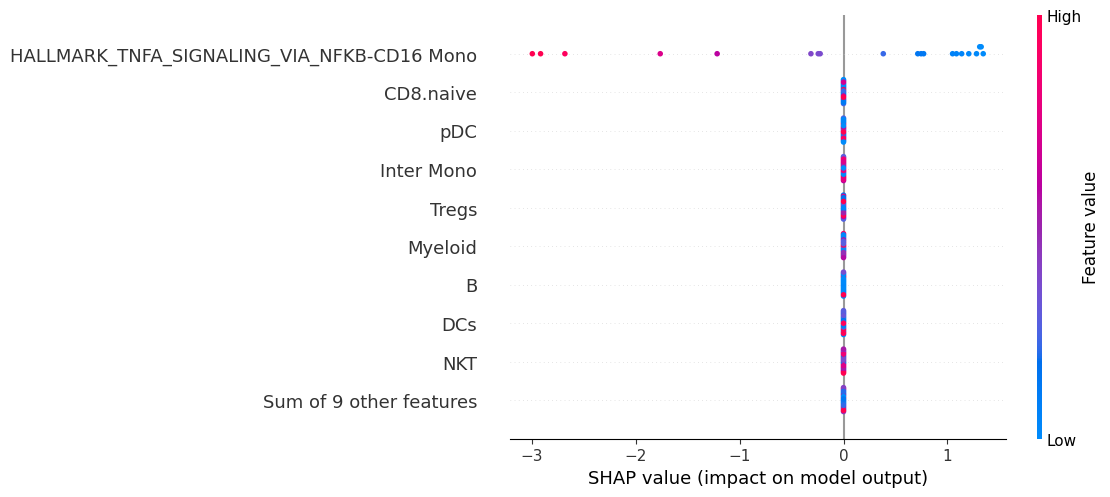

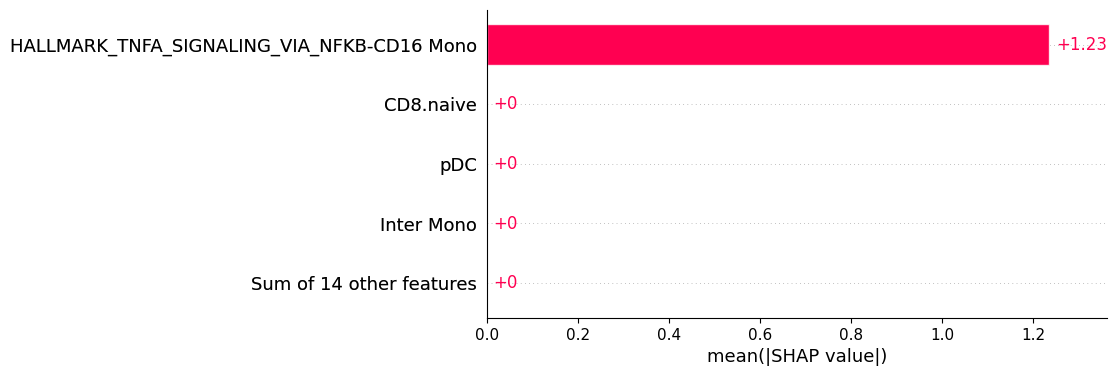

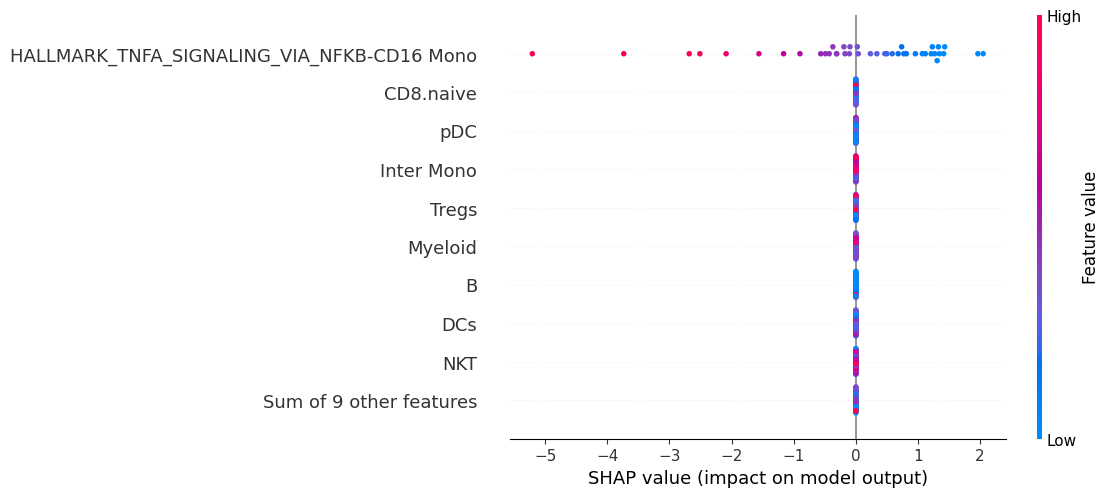

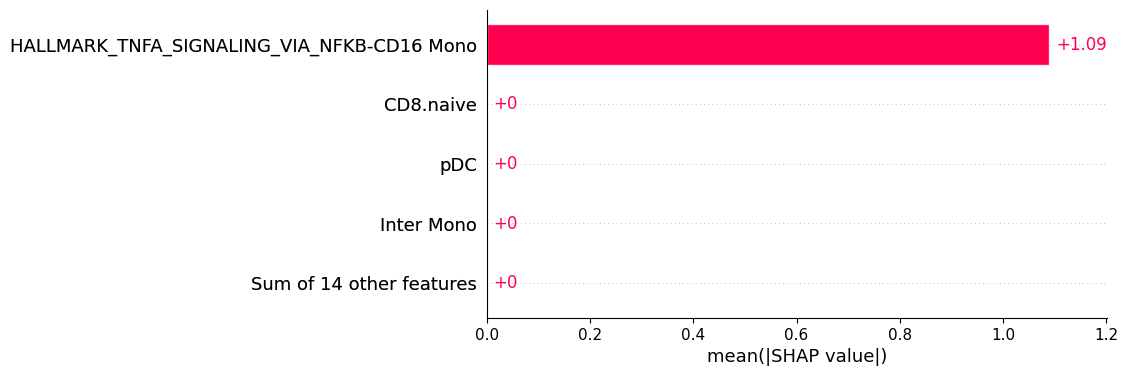

In [297]:
_ = print_shap_plots(best_model, X_hard_test_transformed)
_ = print_shap_plots(best_model, X_trasnformed)

## save all results

In [298]:
from evaluation.experiment_managment import generate_experiment_name

experiment_name = generate_experiment_name(use_cell_frequencies=use_cell_frequencies,
                                           use_TNFA_SIGNALING_VIA_NFKB_CD16_Mono=use_TNFA_SIGNALING_VIA_NFKB_CD16_Mono,
                                           )
experiment_name

'comp_tnfa_via_nfkb_CD16_Mono_results'

In [299]:
all_exp_data = {
    "X": X,
    "y": y,
    'patient_map': patient_map.drop(columns='Unnamed: 0').rename(columns={'sample_id': patient_col}),
    'features': featurs,
    'model': best_model,
    "loocv": {
        'y': y,
        'y_proba': y_proba,
        'y_pred':y_pred
    },
    'test': {
        'X_train':X_train, 
        'X_test': X_test,
        'y':y_test,
        'y_proba':y_test_proba,
        'y_pred':y_test_pred
    },
    'external_eval': {
        "X_train": X_trasnformed,
        "X_test": X_hard_test_transformed,
        'y': y_hard_test, 
        'y_proba': y_hard_test_proba,
        
        'y_pred':y_hard_test_pred
    }
}

In [300]:
import pickle

In [301]:
results_path  = Path(data_dir_path, f"{experiment_name}.pkl")
with open(results_path, 'wb') as handle:
    pickle.dump(all_exp_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [302]:
with open(results_path, 'rb') as handle:
    loaded_results = pickle.load(handle)
loaded_results.keys()

dict_keys(['X', 'y', 'patient_map', 'features', 'model', 'loocv', 'test', 'external_eval'])